In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer

In [2]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#tf.shape(hidden_layer_1M)

In [4]:
class MyDenseLayer(Layer):

    def __init__(self, kernel_initilizer=tf.keras.initializers.Identity(), num_outputs=50, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initilizer)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._b = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._c = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._d = self.add_weight(name='x', 
                                    shape=[
                                         self.num_outputs],
                                    initializer=tf.keras.initializers.Zeros(), #'uniform',
                                    trainable=True)

        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.matmul(tf.nn.relu(x), self._b) - tf.matmul(tf.nn.relu(-x), self._c) + self._d

In [5]:
#Define the discriminator
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)
hidden_layer_6 = Dense(50, activation='relu')(hidden_layer_5)
outputs = Dense(1, activation='sigmoid')(hidden_layer_6)
Discriminator = Model(inputs=inputs, outputs=outputs)
Discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#Define the mapping function:
inputsM = Input((1, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
hidden_layer_3M = MyDenseLayer()(hidden_layer_2M)
hidden_layer_4M = MyDenseLayer()(hidden_layer_3M)
hidden_layer_5M = MyDenseLayer()(hidden_layer_4M)
hidden_layer_6M = MyDenseLayer()(hidden_layer_5M)
hidden_layer_4M = Dense(1, activation='linear', kernel_initializer=initializer)(hidden_layer_6M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_4M)

#Define the generator
inputsG = Input((2, ))
concatenate_layerG = Concatenate()([MappingFunc(inputsG[:,1:2]),inputsG[:,0:1]])
outputG = concatenate_layerG[:, 0]*concatenate_layerG[:, 1]
Generator = Model(inputs=inputsG, outputs=outputG)

#Define the full GAN for training
inputsGAN = Input((2, ))
GAN = Model(inputs=inputsGAN,outputs=Discriminator(Generator(inputsGAN)))
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [6]:
# generate n real samples with class labels
def generate_real_samples(n):
    rng = np.random.default_rng()
    x = rng.normal(0,1,n)
    y = np.ones((n, 1))
    c = np.random.uniform(-1.5,1.5,n)
    X = np.c_[x,c]
    rng.shuffle(X)
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(real_samples,generator, n):
    # predict outputs
    X = np.c_[Generator.predict(real_samples),real_samples[:,1]]
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [7]:
m = 5000
n_batch = m
n_epochs = 5*m
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(x_real, Generator, half_batch)
    Discriminator.train_on_batch(x_real[:,0], y_real)
    Discriminator.train_on_batch(x_fake[:,0], y_fake)
    Discriminator.trainable = False
    # update the generator via the discriminator's error
    loss = GAN.train_on_batch(x_real, np.ones(len(x_real)), return_dict=True)
    Discriminator.trainable = True
    #Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if(i%m == 0):
        print(i,MappingFunc.predict([[1]]))
        print(loss)

0 [[0.9999932]]
{'loss': 0.6953545212745667, 'accuracy': 0.23080000281333923}
5000 [[0.51938707]]
{'loss': 0.40953752398490906, 'accuracy': 1.0}
10000 [[-0.8836677]]
{'loss': 0.4069134294986725, 'accuracy': 1.0}
15000 [[-0.98702157]]
{'loss': 0.40648218989372253, 'accuracy': 1.0}
20000 [[-1.0094347]]
{'loss': 0.4059915244579315, 'accuracy': 1.0}


In [8]:
Generator.predict([[3,-1, -1]])

array([-3.123886], dtype=float32)

In [9]:
MappingFunc.predict([[2,3]])

ValueError: in user code:

    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-4-cb9bc116b530>:29 call  *
        return tf.matmul(tf.nn.relu(x), self._b) - tf.matmul(tf.nn.relu(-x), self._c) + self._d
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:180 wrapper  **
        return target(*args, **kwargs)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:2984 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:5587 mat_mul
        name=name)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /usr/common/software/tensorflow/gpu-tensorflow/2.2.0-py37/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 2 and 1 for '{{node model_1/my_dense_layer/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](model_1/my_dense_layer/Relu, model_1/my_dense_layer/MatMul/ReadVariableOp)' with input shapes: [?,2], [1,50].


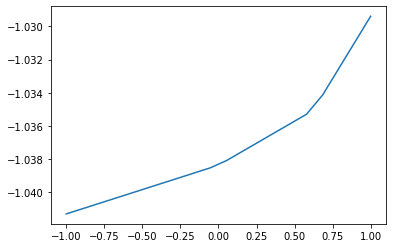

In [10]:
preds = MappingFunc.predict([[c] for c in np.linspace(-1,1,20)])
plt.plot(np.linspace(-1,1,20),preds)

In [11]:
b_i = np.random.uniform(-1.5,1.5,m//10)
b_f = []
c_i = np.random.uniform(-1.5,1.5,m//10)
c_f = []


for j in range(m//10):
    preds = MappingFunc.predict([[c_i[j]]])
    c_f.append(preds[0,0])
    
        

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter(c_i, c_f, b_f,
                c=b_f, cmap='viridis', linewidth=0.5)

Text(0, 0.5, 'final slope')

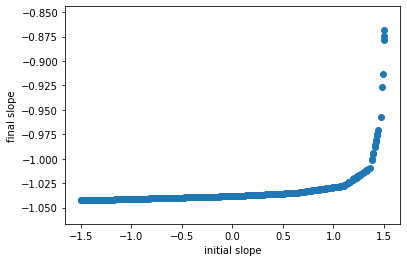

In [12]:
plt.scatter(c_i, c_f)
plt.xlabel("initial slope")
plt.ylabel("final slope")

In [ ]:
plt.scatter(b_i, b_f)
plt.xlabel("initial intercept")
plt.ylabel("final intercept")

In [20]:
x_real, y_real = generate_real_samples(10000)
x_fake, y_fake = generate_fake_samples(x_real, Generator, 10000)

(array([ 296.,  750., 1261., 1504., 1686., 1622., 1260.,  781.,  368.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

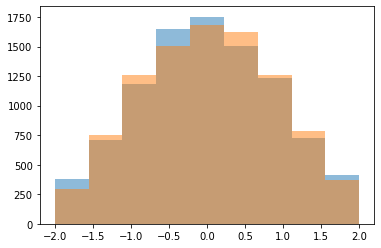

In [21]:
plt.hist(x_real[:,0],bins=np.linspace(-2,2,10),alpha=0.5)
plt.hist(x_fake[:,0],bins=np.linspace(-2,2,10),alpha=0.5)

In [22]:
np.mean(x_real[:,0])

0.013106663292561518

In [23]:
np.mean(x_fake[:,0])

0.024641594898374752

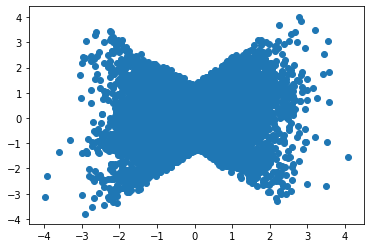

In [24]:
plt.scatter(x_real[:,0],x_fake[:,0])